# Kaggle Bag of Popcorn challenge
>In this tutorial competition, we dig a little "deeper" into sentiment analysis. Google's Word2Vec is a deep-learning inspired method that focuses on the meaning of words. Word2Vec attempts to understand meaning and semantic relationships among words. It works in a way that is similar to deep approaches, such as recurrent neural nets or deep neural nets, but is computationally more efficient. This tutorial focuses on Word2Vec for sentiment analysis.
>
>Sentiment analysis is a challenging subject in machine learning. People express their emotions in language that is often obscured by sarcasm, ambiguity, and plays on words, all of which could be very misleading for both humans and computers. There's another Kaggle competition for movie review sentiment analysis. In this tutorial we explore how Word2Vec can be applied to a similar problem.
>
>Deep learning has been in the news a lot over the past few years, even making it to the front page of the New York Times. These machine learning techniques, inspired by the architecture of the human brain and made possible by recent advances in computing power, have been making waves via breakthrough results in image recognition, speech processing, and natural language tasks. Recently, deep learning approaches won several Kaggle competitions, including a drug discovery task, and cat and dog image recognition.
>
>__Tutorial Overview__
>
>This tutorial will help you get started with Word2Vec for natural language processing. It has two goals: 
>
>Basic Natural Language Processing: Part 1 of this tutorial is intended for beginners and covers basic natural language processing techniques, which are needed for later parts of the tutorial.
>
>Deep Learning for Text Understanding: In Parts 2 and 3, we delve into how to train a model using Word2Vec and how to use the resulting word vectors for sentiment analysis.
>
>Since deep learning is a rapidly evolving field, large amounts of the work has not yet been published, or exists only as academic papers. Part 3 of the tutorial is more exploratory than prescriptive -- we experiment with several ways of using Word2Vec rather than giving you a recipe for using the output.
>
>To achieve these goals, we rely on an IMDB sentiment analysis data set, which has 100,000 multi-paragraph movie reviews, both positive and negative. 

In this notebook, I will use deep learning models in an effort to improve predictions over the BOW and Word2Vec approaches

## Load the Data

In [1]:
# Load the data
import pandas as pd

train_data = pd.read_csv('labeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
unlabeled_data = pd.read_csv('unlabeledTrainData.tsv', header=0, delimiter='\t', quoting=3)
submission_data = pd.read_csv('testData.tsv', header=0, delimiter='\t', quoting=3)

print('Labeled training data shape: ', train_data.shape)
print('Unlabeled training data shape: ', unlabeled_data.shape)
print('Submission data shape: ', submission_data.shape)

Labeled training data shape:  (25000, 3)
Unlabeled training data shape:  (50000, 2)
Submission data shape:  (25000, 2)


In [2]:
import numpy as np

all_reviews = np.array([], dtype=str)
for data in [train_data, unlabeled_data, submission_data]:
    all_reviews = np.concatenate((all_reviews, data['review']), axis=0)

print('Number of reviews: ', len(all_reviews))

Number of reviews:  100000


## Text Preprocessing

In [3]:
from bs4 import BeautifulSoup
import nltk
import re
import numpy as np

wpt = nltk.WordPunctTokenizer()

# convert from list to set b/c in Python searching a set is much faster than searching a list
# Not shown here, but the difference in speed for this data set is nearly 4-fold, i.e., 
# searching the list takes about 4x longer than searching a set. 
stop_words = set(nltk.corpus.stopwords.words('english'))

def clean_text(text):
    # strip html tags
    text = BeautifulSoup(text, "html.parser").get_text()
    
    # lower case, remove special characters, and strip leading and trailing whitespaces
    text = re.sub(r'[^a-zA-Z\s]', ' ', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    
    # tokenize
    tokens = wpt.tokenize(text)
    
    # filter out stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # Join text back
    text = ' '.join(filtered_tokens)
    return text

In [4]:
%%time
clean_reviews = [clean_text(review) for review in all_reviews]

Wall time: 27.2 s


In [5]:
print(clean_reviews[2])

film starts manager nicholas bell giving welcome investors robert carradine primal park secret project mutating primal animal using fossilized dna like jurassik park scientists resurrect one nature fearsome predators sabretooth tiger smilodon scientific ambition turns deadly however high voltage fence opened creature escape begins savagely stalking prey human visitors tourists scientific meanwhile youngsters enter restricted area security center attacked pack large pre historical animals deadlier bigger addition security agent stacy haiduk mate brian wimmer fight hardly carnivorous smilodons sabretooths course real star stars astounding terrifyingly though convincing giant animals savagely stalking prey group run afoul fight one nature fearsome predators furthermore third sabretooth dangerous slow stalks victims movie delivers goods lots blood gore beheading hair raising chills full scares sabretooths appear mediocre special effects story provides exciting stirring entertainment result

## Split the data

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    clean_reviews[:train_data.shape[0]], train_data['sentiment'], test_size=0.2,
    shuffle=True, random_state=0)
X_submission = clean_reviews[-submission_data.shape[0]:]

In [7]:
print(len(X_train), len(y_train))
print(len(X_val), len(y_val))
print(len(X_submission))

20000 20000
5000 5000
25000


## Prepare text for RNN

In [8]:
# Initialize parameters
np.random.seed(32)
input_length = 500 # length of each review
embed_size = 100 # Embedding dimension of each word vector
freq_words = 5000 # Most frequent words to keep

In [9]:
%%time
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=freq_words)
tokenizer.fit_on_texts(clean_reviews)

X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=input_length)
X_submission = pad_sequences(tokenizer.texts_to_sequences(X_submission), maxlen=input_length)

Using TensorFlow backend.


Wall time: 11.9 s


## RNN Model Architecture

In [10]:
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPool1D, Dense, \
    CuDNNLSTM, CuDNNGRU, Bidirectional
from keras.models import Sequential
from keras.callbacks import TensorBoard

In [11]:
def build_model(freq_words, input_length, embed_size, use_cnn=True, use_lstm=False, use_bidirectional=False):
    model = Sequential()
    model.add(Embedding(
        input_dim = freq_words,
        output_dim = embed_size,
        input_length = input_length))
    model.add(Dropout(0.4))
    if use_cnn:
        model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
        model.add(MaxPool1D(pool_size=2))
    
    # Add GRU layers. Will use cuda implementation of keras, which runs much faster on 
    # GPU than the normal GRU or LSTM layer
    if use_lstm and not use_bidirectional:
        model.add(CuDNNLSTM(100))
    elif use_lstm and use_bidirectional:
        model.add(Bidirectional(CuDNNLSTM(100)))
    else:
        model.add(CuDNNGRU(100))
    
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

### GRU model

In [13]:
gru_model = build_model(freq_words=freq_words, input_length=input_length, 
                        embed_size=embed_size, use_lstm=False)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [14]:
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 100)          500000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           9632      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
cu_dnngru_2 (CuDNNGRU)       (None, 100)               40200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total para

In [15]:
%%time

# Set log data to feed to TensorBoard for visual analysis
tensor_board = TensorBoard('.logs\GRU')

# Fit the model
gru_history = gru_model.fit(X_train, y_train, batch_size=64, epochs=3, 
              validation_data=[X_val, y_val], callbacks=[tensor_board])




Train on 20000 samples, validate on 5000 samples







Epoch 1/3
20000/20000 [==============================] - 8s 420us/step - loss: 0.4771 - acc: 0.7642 - val_loss: 0.3323 - val_acc: 0.8578

Epoch 2/3
20000/20000 [==============================] - 7s 356us/step - loss: 0.2520 - acc: 0.9020 - val_loss: 0.2959 - val_acc: 0.8748
Epoch 3/3
20000/20000 [==============================] - 7s 356us/step - loss: 0.1988 - acc: 0.9245 - val_loss: 0.3048 - val_acc: 0.8808
Wall time: 25 s


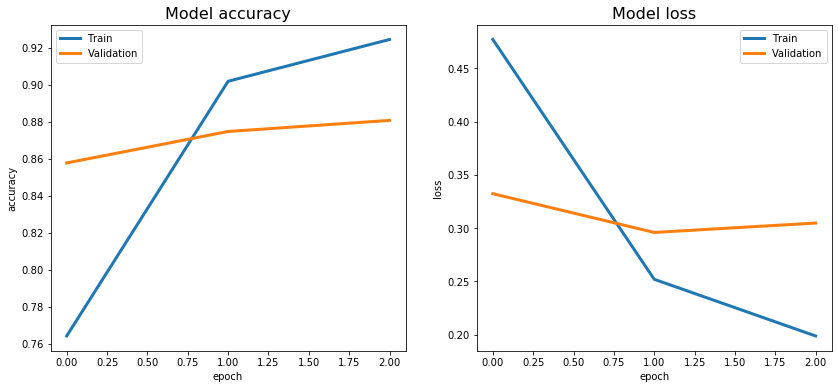

In [16]:
import matplotlib.pyplot as plt

fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# summarize history for accuracy
axis1.plot(gru_history.history['acc'], label='Train', linewidth=3)
axis1.plot(gru_history.history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(gru_history.history['loss'], label='Train', linewidth=3)
axis2.plot(gru_history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [17]:
y_train_pred_gru = gru_model.predict_classes(X_train)
y_val_pred_gru = gru_model.predict_classes(X_val)
y_submission_pred_gru = gru_model.predict_classes(X_submission)

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, ax, vmax=None,
                          normed=True, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    if normed:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmax=vmax, annot=True, square=True, ax=ax, 
                cmap='Blues', cbar=False, linecolor='k',
               linewidths=1)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)

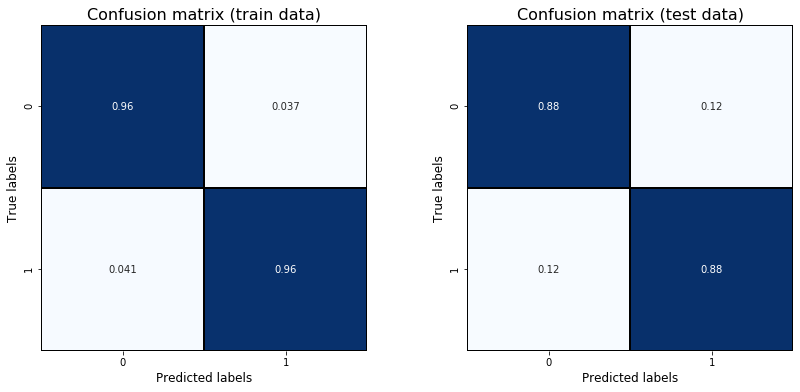

In [19]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_confusion_matrix(y_train, y_train_pred_gru, ax=axis1,
                      title='Confusion matrix (train data)')
plot_confusion_matrix(y_val, y_val_pred_gru, ax=axis2,
                      title='Confusion matrix (test data)')

In [20]:
from sklearn.metrics import classification_report
print('Classification report on Test set: \n', classification_report(y_val, y_val_pred_gru))

Classification report on Test set: 
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      2548
           1       0.88      0.88      0.88      2452

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



### LSTM Model

In [21]:
lstm_model = build_model(freq_words=freq_words, input_length=input_length, embed_size=embed_size, 
                         use_lstm=True, use_bidirectional=False)

In [22]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 100)          500000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 32)           9632      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 100)               53600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total para

In [23]:
%%time

# Set log data to feed to TensorBoard for visual analysis
tensor_board = TensorBoard('.logs\LSTM')

# Fit the model
lstm_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=3, 
              validation_data=[X_val, y_val], callbacks=[tensor_board])

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 7s 334us/step - loss: 0.4730 - acc: 0.7595 - val_loss: 0.3079 - val_acc: 0.8706
Epoch 2/3
20000/20000 [==============================] - 6s 316us/step - loss: 0.2548 - acc: 0.8982 - val_loss: 0.2834 - val_acc: 0.8802
Epoch 3/3
20000/20000 [==============================] - 6s 317us/step - loss: 0.2083 - acc: 0.9196 - val_loss: 0.2973 - val_acc: 0.8778
Wall time: 20.1 s


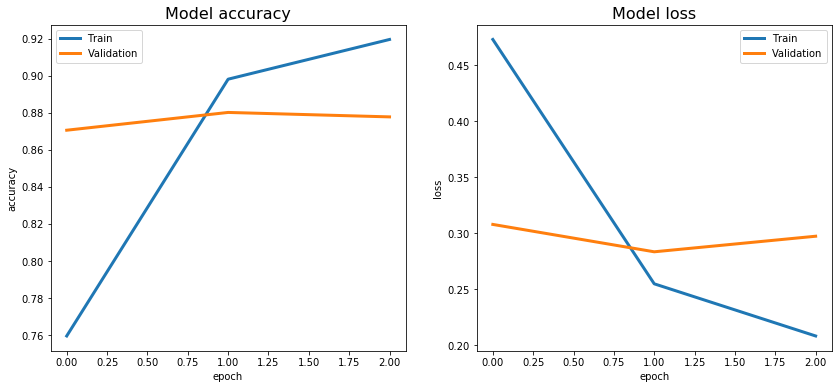

In [24]:
import matplotlib.pyplot as plt 

fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# summarize history for accuracy
axis1.plot(lstm_history.history['acc'], label='Train', linewidth=3)
axis1.plot(lstm_history.history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(lstm_history.history['loss'], label='Train', linewidth=3)
axis2.plot(lstm_history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [25]:
y_train_pred_lstm = lstm_model.predict_classes(X_train)
y_val_pred_lstm = lstm_model.predict_classes(X_val)
y_submission_pred_lstm = lstm_model.predict_classes(X_submission)

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, ax, vmax=None,
                          normed=True, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    if normed:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmax=vmax, annot=True, square=True, ax=ax, 
                cmap='Blues', cbar=False, linecolor='k',
               linewidths=1)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)

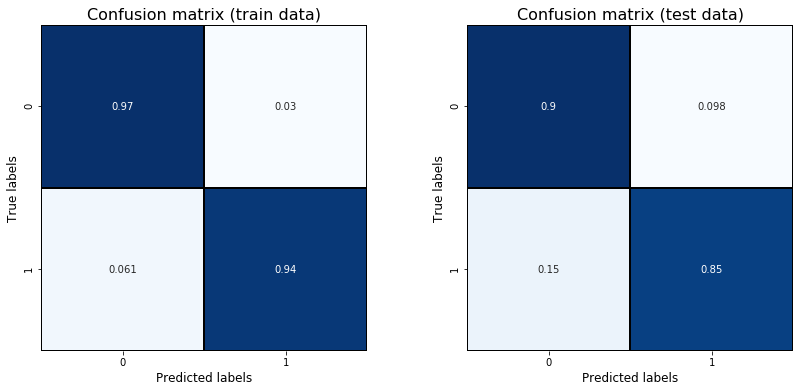

In [27]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_confusion_matrix(y_train, y_train_pred_lstm, ax=axis1,
                      title='Confusion matrix (train data)')
plot_confusion_matrix(y_val, y_val_pred_lstm, ax=axis2,
                      title='Confusion matrix (test data)')

In [28]:
from sklearn.metrics import classification_report
print('Classification report on Test set: \n', classification_report(y_val, y_val_pred_lstm))

Classification report on Test set: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      2548
           1       0.89      0.85      0.87      2452

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



### Bidirectional LSTM

In [34]:
bilstm_model = build_model(freq_words=freq_words, input_length=input_length, embed_size=embed_size, 
                           use_cnn=False, use_lstm=True, use_bidirectional=True)

In [35]:
bilstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 100)          500000    
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               161600    
_________________________________________________________________
dropout_9 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 661,801
Trainable params: 661,801
Non-trainable params: 0
_________________________________________________________________


In [36]:
%%time

# Set log data to feed to TensorBoard for visual analysis
tensor_board = TensorBoard('.logs\BiLSTM')

# Fit the model
bilstm_history = bilstm_model.fit(X_train, y_train, batch_size=128, epochs=3, 
              validation_data=[X_val, y_val], callbacks=[tensor_board])

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 20s 1ms/step - loss: 0.4736 - acc: 0.7619 - val_loss: 0.3158 - val_acc: 0.8732
Epoch 2/3
20000/20000 [==============================] - 22s 1ms/step - loss: 0.2700 - acc: 0.8946 - val_loss: 0.3188 - val_acc: 0.8682
Epoch 3/3
20000/20000 [==============================] - 22s 1ms/step - loss: 0.2169 - acc: 0.9166 - val_loss: 0.3016 - val_acc: 0.8816
Wall time: 1min 4s


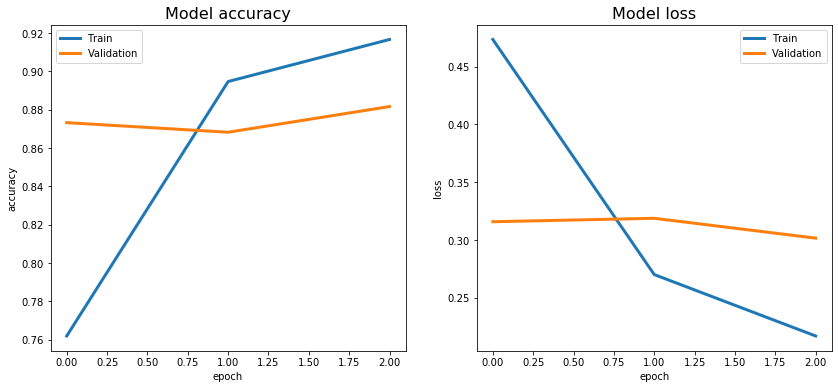

In [37]:
import matplotlib.pyplot as plt

fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14,6))

# summarize history for accuracy
axis1.plot(bilstm_history.history['acc'], label='Train', linewidth=3)
axis1.plot(bilstm_history.history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(bilstm_history.history['loss'], label='Train', linewidth=3)
axis2.plot(bilstm_history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [38]:
y_train_pred_bilstm = bilstm_model.predict_classes(X_train)
y_val_pred_bilstm = bilstm_model.predict_classes(X_val)
y_submission_pred_bilstm = bilstm_model.predict_classes(X_submission)

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, ax, vmax=None,
                          normed=True, title='Confusion matrix'):
    cm = confusion_matrix(y_true, y_pred)
    if normed:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmax=vmax, annot=True, square=True, ax=ax, 
                cmap='Blues', cbar=False, linecolor='k',
               linewidths=1)
    ax.set_title(title, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)

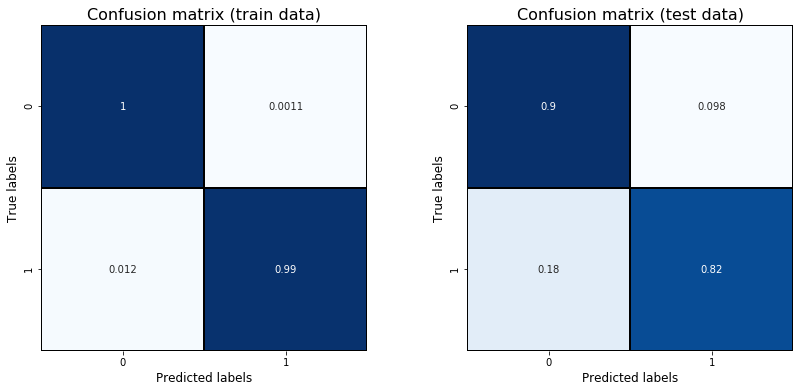

In [22]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_confusion_matrix(y_train, y_train_pred_bilstm, ax=axis1,
                      title='Confusion matrix (train data)')
plot_confusion_matrix(y_val, y_val_pred_bilstm, ax=axis2,
                      title='Confusion matrix (test data)')

In [23]:
from sklearn.metrics import classification_report
print('Classification report on Test set: \n', classification_report(y_val, y_val_pred_bilstm))

Classification report on Test set: 
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      2548
           1       0.89      0.82      0.85      2452

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000

